## US Airline Sentiment Analytics

Kali ini, kita akan melakukan sentimen analisis terhadap data US Airline yang dihimpun dari data Twitter atau unggahan penggunah airline dalam bentuk tulisan (*tweets*). Sumber dataset yang digunakan adalah `Twitter` dalam rentang waktu 2015-02-17 hingga 2015-02-24.

**Limitations**
<br>Analisis kali ini kita hanya akan melakukan **Exploration Data Analysis** dan percobaan singkat mengenai analisis klasifikasi polaritas menggunakan beberapa model klasifikasi.

In [148]:
! pip install wordcloud

## Import Modules dan Dataset

In [149]:
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
from sklearn.model_selection import train_test_split
import numpy

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from nltk.stem import PorterStemmer


from textblob import TextBlob
from textblob import Word

import warnings
warnings.filterwarnings('ignore')

In [150]:
twit= pandas.read_csv("twit.csv")
twit.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,NaN,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,NaN,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
3,567592368451248130,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,NaN,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,NaN,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


In [151]:
print("Ukuran dataset",twit.shape)

Ukuran dataset (14485, 15)


In [152]:
(len(twit)-twit.count())/len(twit)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373007
negativereason_confidence       0.280911
airline                         0.000000
airline_sentiment_gold          0.997239
name                            0.000000
negativereason_gold             0.997791
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930480
tweet_created                   0.000000
tweet_location                  0.323576
user_timezone                   0.329651
dtype: float64

In [153]:
twit.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5403
negativereason_confidence        4069
airline                             0
airline_sentiment_gold          14445
name                                0
negativereason_gold             14453
retweet_count                       0
text                                0
tweet_coord                     13478
tweet_created                       0
tweet_location                   4687
user_timezone                    4775
dtype: int64

#### Delete Kolom

Keputusan untuk menghapus kolom `tweet_coord`, `airline_sentiment_gold`, dan `negativereason_gold` adalah karena banyaknya nilai missing values yang dimiliki oleh kolom tersebut dan tidak berdampak pada kumpulan dataset.

In [154]:
del twit['tweet_coord']
del twit['airline_sentiment_gold']
del twit['negativereason_gold']

### Drop Data Duplikat

Menghapus tweets yang terduplikat pada dataset apabila memang ada, hal ini dilakukan untuk menjaga keaslian data uji.

In [155]:
unique_id = set()
for item in twit['text']:
        unique_id.add(item)
new_twit = []
for item in unique_id:
    new_twit.append(item)
    data_text = pandas.DataFrame(new_twit,columns = ['update'])

In [156]:
twit_id = twit[twit['text'].isin(data_text['update'].tolist())]
data_text['tweet_id'] = twit_id['tweet_id']
data_text.head()

,update,tweet_id
0,@SouthwestAir please help on hold forever to c...,567588278875213824
1,@united looks like today will be my 6th consec...,567590027375702016
2,@united Just submitted my response on the link...,567591480085463040
3,@SouthwestAir @TheAcademy party in #hotlanta h...,567592368451248130
4,@united please arrange someone at the arriving...,567594449874587648


### Text Lower Casing
Mengubah keseluruhan data text menjadi *lower-case*

In [157]:
data_text['update'] = data_text['update'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_text['update'].head()

0    @southwestair please help on hold forever to c...
1    @united looks like today will be my 6th consec...
2    @united just submitted my response on the link...
3    @southwestair @theacademy party in #hotlanta h...
4    @united please arrange someone at the arriving...
Name: update, dtype: object

### Punctual Removal

Mehilangkan regular punctuation dalam setiap data text

In [158]:
data_text['update'] = data_text['update'].str.replace('[^\w\s]','')
data_text.head()

,update,tweet_id
0,southwestair please help on hold forever to ch...,567588278875213824
1,united looks like today will be my 6th consecu...,567590027375702016
2,united just submitted my response on the link ...,567591480085463040
3,southwestair theacademy party in hotlanta http...,567592368451248130
4,united please arrange someone at the arriving ...,567594449874587648


### Stopword Removal

In [159]:
stop = stopwords.words('english')
data_text['update'] = data_text['update'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_text['update'].head()

0    southwestair please help hold forever check fl...
1    united looks like today 6th consecutive delaye...
2                  united submitted response link sent
3    southwestair theacademy party hotlanta httptco...
4    united please arrange someone arriving gate fl...
Name: update, dtype: object

### Frequent Word Removal
Menghilangkan kata-kata perulangan yang muncul berkali-kali dan bisa juga dimanfaatkan untuk mengatasi text spam pada dataset.

In [160]:
freq = pandas.Series(' '.join(data_text['update']).split()).value_counts()[:10]
freq = list(freq.index)
data_text['update'] = data_text['update'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data_text['update'].head()

0                       please help hold forever check
1    looks like today 6th consecutive delayed youdo...
2                         submitted response link sent
3          theacademy party hotlanta httptcox5zqssjtrb
4    please arrange someone arriving gate 5957 chic...
Name: update, dtype: object

### Rare Words Removal

In [161]:
rare_word = pandas.Series(' '.join(data_text['update']).split()).value_counts()[-10:]
rare_word = list(rare_word.index)
data_text['update'] = data_text['update'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data_text['update'].head()

0                       please help hold forever check
1    looks like today 6th consecutive delayed youdo...
2                         submitted response link sent
3          theacademy party hotlanta httptcox5zqssjtrb
4    please arrange someone arriving gate 5957 chic...
Name: update, dtype: object

### Typos Correction

In [162]:
data_text['update'][:5].apply(lambda x: str(TextBlob(x).correct()))
data_text.head()

,update,tweet_id
0,please help hold forever check,567588278875213824
1,looks like today 6th consecutive delayed youdo...,567590027375702016
2,submitted response link sent,567591480085463040
3,theacademy party hotlanta httptcox5zqssjtrb,567592368451248130
4,please arrange someone arriving gate 5957 chic...,567594449874587648


### Lemmatization

In [163]:
import nltk
nltk.download('wordnet')

data_text['update'] = data_text['update'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data_text['update'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andimu064127\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                       please help hold forever check
1    look like today 6th consecutive delayed youdo ...
2                         submitted response link sent
3          theacademy party hotlanta httptcox5zqssjtrb
4    please arrange someone arriving gate 5957 chic...
Name: update, dtype: object

## Eksplorasi Data (Count, Plot, Analyze Bar, dll)

Dalam sentimen analisis terdapat beberapa hal penting, yaitu

* `Subjek`, adalah orang yang melakukan penyampaian opini
* `Opini`, adalah sentimen yang ditujukan kepada objek terkait
* `Polaritas` adalah kecenderungan nilai opini yang dilontarkan (positif, negatif, netral)

In [164]:
polaritas=twit['airline_sentiment'].value_counts()
polaritas

negative    9082
neutral     3069
positive    2334
Name: airline_sentiment, dtype: int64

Text(0.5,1,'Count of Moods')

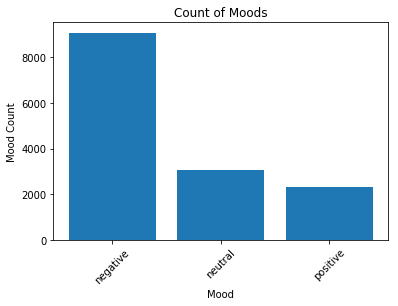

In [165]:
Index = [1,2,3]
plt.bar(Index,polaritas)
plt.xticks(Index,['negative','neutral','positive'],rotation=45)
plt.ylabel('Mood Count')
plt.xlabel('Mood')
plt.title('Count of Moods')

In [181]:
twit['airline'].value_counts()

United            3822
US Airways        2913
American          2604
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

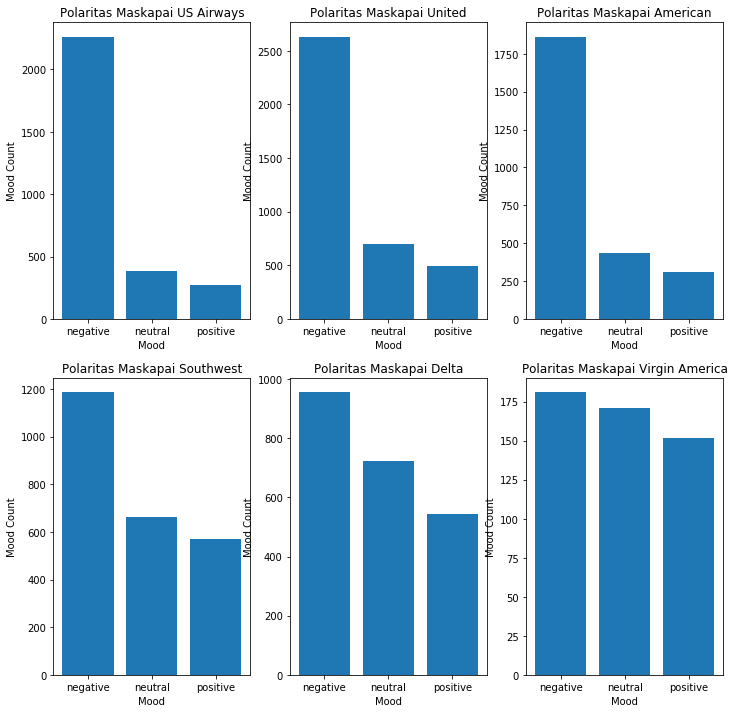

In [182]:
def plot_sub_sentiment(Airline):
    df=twit[twit['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Polaritas Maskapai '+Airline)
    
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

#### Plot Analysis

Pada hasil analisis plot di atas, dapat kita simpulan untuk 3 maskapai pertama (`US Airways`, `United`, dan `American`) memiliki distribusi yang sangat timpang terhadap polaritas negatif (*skewed toward negative polarity*) dan 3 maskapai terakhir (`Southwest`, `Delta`, dan `Virgin America`) memiliki distribusi yang cukup merata antara ketiga polaritasnya. 

#### Reasoning Analysis

In [183]:
analyze_NR=dict(twit['negativereason'].value_counts(sort=False))

In [184]:
def analyze_NR(Airline):
    if Airline=='All':
        df=twit
    else:
        df=twit[twit['airline']==Airline]
    count=dict(df['negativereason'].value_counts())
    Unique_reason=list(twit['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pandas.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

In [185]:
def plot_reason(Airline):
    df=analyze_NR(Airline)
    count=df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

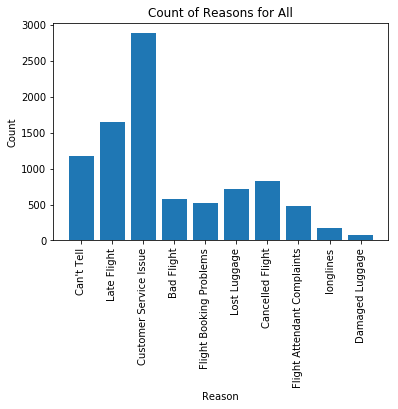

In [186]:
plot_reason('All')

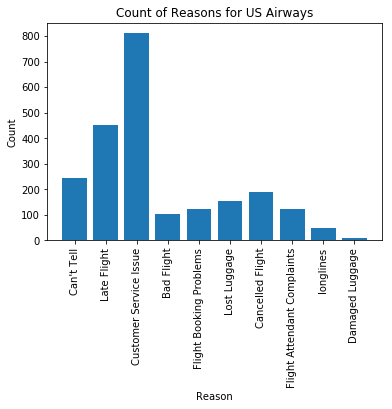

In [187]:
plot_reason('US Airways')

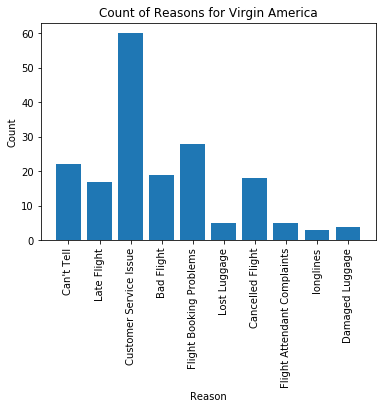

In [188]:
plot_reason('Virgin America')

Dapat disimpulkan secara garis besar rata-rata komplain negatif setiap maskapai (`All`) adalah dikarenakan oleh **`Customer Service Issue`**

### Wordcloud Polaritas Negatif dan Positif

In [174]:
from wordcloud import WordCloud,STOPWORDS

df=twit[twit['airline_sentiment']=='negative']
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [175]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

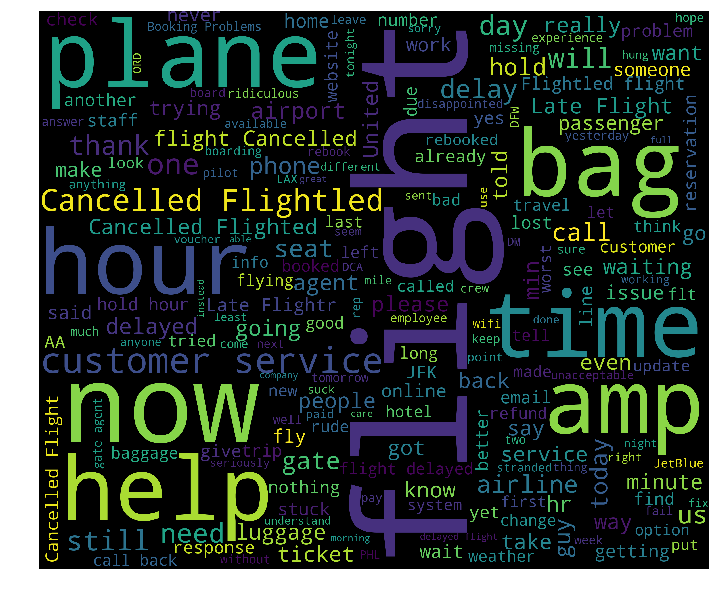

In [176]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [177]:
df1=twit[twit['airline_sentiment']=='positive']
words = ' '.join(df1['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [178]:
wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

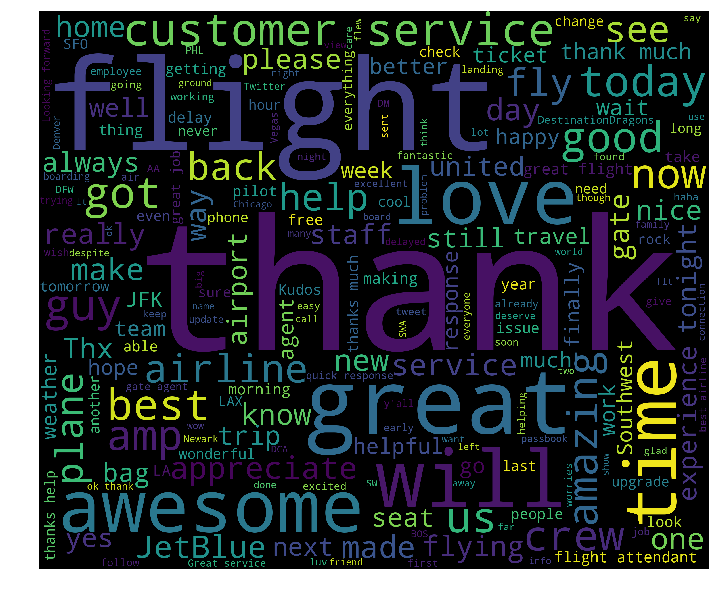

In [179]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

### Classification Model Analysis

In [136]:
import re
import nltk
from nltk.corpus import stopwords

In [137]:
def twit_to_words(raw_twit):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_twit) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [138]:
def clean_twit_length(raw_twit):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_twit) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 


In [139]:
twit['sentiment']=twit['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [140]:
twit['clean_twit']=twit['text'].apply(lambda x: twit_to_words(x))
twit['twit_length']=twit['text'].apply(lambda x: clean_twit_length(x))
train,test = train_test_split(twit,test_size=0.2,random_state=42)

In [141]:
train_clean_twit=[]
for twit in train['clean_twit']:
    train_clean_twit.append(twit)
test_clean_twit=[]
for twit in test['clean_twit']:
    test_clean_twit.append(twit)

In [142]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_twit)
test_features=v.transform(test_clean_twit)

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [144]:
Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

In [145]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy)) 

Accuracy of LogisticRegression is 0.6154642733862616
Accuracy of KNeighborsClassifier is 0.6061442871936487
Accuracy of SVC is 0.6154642733862616
Accuracy of DecisionTreeClassifier is 0.7324818778046255
Accuracy of RandomForestClassifier is 0.795650673110114
Accuracy of AdaBoostClassifier is 0.7707973765964791
Accuracy of GaussianNB is 0.5992405937176389


Text(0.5,1,'Akurasi Model Prediksi')

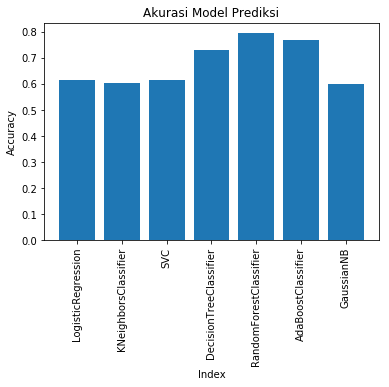

In [189]:
Index = ['LogReg', 'KNN', 'SVC', 'Decision Tree', 'Random Forest', 'AdaBoost', 'GaussianNB']
plt.bar(Index,Accuracy)
plt.xticks(Index, Model,rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Index')
plt.title('Akurasi Model Prediksi')

### Classification Analysis

Dari uji terhadap dataset ini, dapat disimpulkan bahwa untuk dilakukan analisis klasifikasi polaritas yang tepat ialah menggunakan model **`Random Forest Classifier`**, karena model ini memiliki tingkat akurasi yang paling tinggi dan cukup *reasonable*, yaitu sebesar 0.795 atau 80%